# NIBRS Data Validation: Incident Time Availability

**Purpose**: Verify that NIBRS microdata contains **incident time (hour)** for our moonlight-crime analysis.

**Source**: [Jacob Kaplan's Concatenated NIBRS Files](https://www.openicpsr.org/openicpsr/project/118281) (1991-2024)

**Key Finding**: The `incident_date_hour` column provides hour-level granularity for each incident.

In [1]:
library(tidyverse)

Warning message:
"package 'tidyverse' was built under R version 4.4.2"
Warning message:
"package 'tibble' was built under R version 4.4.2"
Warning message:
"package 'tidyr' was built under R version 4.4.2"
Warning message:
"package 'readr' was built under R version 4.4.2"
Warning message:
"package 'purrr' was built under R version 4.4.3"
Warning message:
"package 'dplyr' was built under R version 4.4.2"
Warning message:
"package 'stringr' was built under R version 4.4.2"
Warning message:
"package 'forcats' was built under R version 4.4.2"
Warning message:
"package 'lubridate' was built under R version 4.4.2"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()

## 1. Load Sample Data (2019)

In [2]:
# Load 2019 administrative segment (within our study period 2013-2020)
admin_2019 <- readRDS("../data/alexr_icprsr_crime_data/administrative_segment/nibrs_administrative_segment_2019.rds")

cat("Total incidents in 2019:", format(nrow(admin_2019), big.mark=","), "\n")
cat("Columns:", ncol(admin_2019))

Total incidents in 2019: 6,862,909 
Columns: 16

## 2. Verify Incident Time Column Exists

In [3]:
# Show all column names
cat("Available columns:\n")
print(names(admin_2019))

Available columns:
 [1] "ori"                        "year"                      
 [3] "state"                      "state_abb"                 
 [5] "incident_number"            "incident_date"             
 [7] "report_date_indicator"      "incident_date_hour"        
 [9] "total_offense_segments"     "total_victim_segments"     
[11] "total_offender_segments"    "total_arrestee_segments"   
[13] "city_submissions"           "cleared_exceptionally"     
[15] "exceptional_clearance_date" "unique_incident_id"        


In [4]:
# Show sample values from the incident_date_hour column
cat("Sample values from 'incident_date_hour' column:\n\n")
admin_2019 |>
    select(incident_date, incident_date_hour) |>
    head(15)

Sample values from 'incident_date_hour' column:



,incident_date,incident_date_hour
,<chr>,<chr>
1,2019-04-08,on or between 08:00 and 08:59
2,2019-08-01,on or between 16:00 and 16:59
3,2019-10-19,on or between 10:00 and 10:59
4,2019-10-01,on or between midnight and 00:59
5,2019-08-02,on or between midnight and 00:59
6,2019-10-29,on or between 15:00 and 15:59
7,2019-10-01,on or between 08:00 and 08:59
8,2019-03-13,on or between 11:00 and 11:59
9,2019-09-01,on or between 08:00 and 08:59


## 3. Data Completeness Check

In [5]:
# Check missing values in the time column
n_total <- nrow(admin_2019)
n_missing <- sum(is.na(admin_2019$incident_date_hour))
n_valid <- n_total - n_missing
pct_valid <- round(100 * n_valid / n_total, 2)

cat("=== INCIDENT TIME COMPLETENESS ===", "\n\n")
cat("Total incidents:        ", format(n_total, big.mark=","), "\n")
cat("With time info:         ", format(n_valid, big.mark=","), "\n")
cat("Missing time:           ", format(n_missing, big.mark=","), "\n")
cat("Completeness:           ", pct_valid, "%\n")

=== INCIDENT TIME COMPLETENESS === 

Total incidents:         6,862,909 
With time info:          6,862,909 
Missing time:            0 
Completeness:            100 %


## 4. Parse Hour and Analyze Distribution

In [6]:
# Parse the hour from strings like "on or between 08:00 and 08:59"
admin_2019 <- admin_2019 |>
    mutate(
        # Extract hour: handle "midnight" as 0, otherwise extract first 2 digits after "between "
        incident_hour = case_when(
            str_detect(incident_date_hour, "midnight") ~ 0L,
            TRUE ~ as.integer(str_extract(incident_date_hour, "(?<=between )\\d{2}"))
        ),
        # Create nighttime flag (6 PM to 6 AM)
        is_nighttime = incident_hour >= 18 | incident_hour < 6
    )

# Show parsing worked
cat("Sample of parsed hours:\n\n")
admin_2019 |>
    filter(!is.na(incident_hour)) |>
    select(incident_date_hour, incident_hour, is_nighttime) |>
    distinct() |>
    arrange(incident_hour) |>
    head(24)

Sample of parsed hours:



,incident_date_hour,incident_hour,is_nighttime
,<chr>,<int>,<lgl>
1,on or between midnight and 00:59,0,TRUE
2,on or between 01:00 and 01:59,1,TRUE
3,on or between 02:00 and 02:59,2,TRUE
4,on or between 03:00 and 03:59,3,TRUE
5,on or between 04:00 and 04:59,4,TRUE
6,on or between 05:00 and 05:59,5,TRUE
7,on or between 06:00 and 06:59,6,FALSE
8,on or between 07:00 and 07:59,7,FALSE
9,on or between 08:00 and 08:59,8,FALSE


In [7]:
# Distribution by hour
hour_dist <- admin_2019 |>
    filter(!is.na(incident_hour)) |>
    count(incident_hour) |>
    mutate(pct = round(100 * n / sum(n), 2))

cat("Incidents by Hour of Day (2019):\n\n")
print(as.data.frame(hour_dist))

Incidents by Hour of Day (2019):

   incident_hour      n  pct
1              0 608227 8.86
2              1 202505 2.95
3              2 166366 2.42
4              3 124774 1.82
5              4  95454 1.39
6              5  86363 1.26
7              6 109174 1.59
8              7 158726 2.31
9              8 282351 4.11
10             9 265671 3.87
11            10 292180 4.26
12            11 300070 4.37
13            12 425624 6.20
14            13 325675 4.75
15            14 347645 5.07
16            15 372944 5.43
17            16 375153 5.47
18            17 385703 5.62
19            18 370668 5.40
20            19 340569 4.96
21            20 342977 5.00
22            21 318893 4.65
23            22 306084 4.46
24            23 259113 3.78


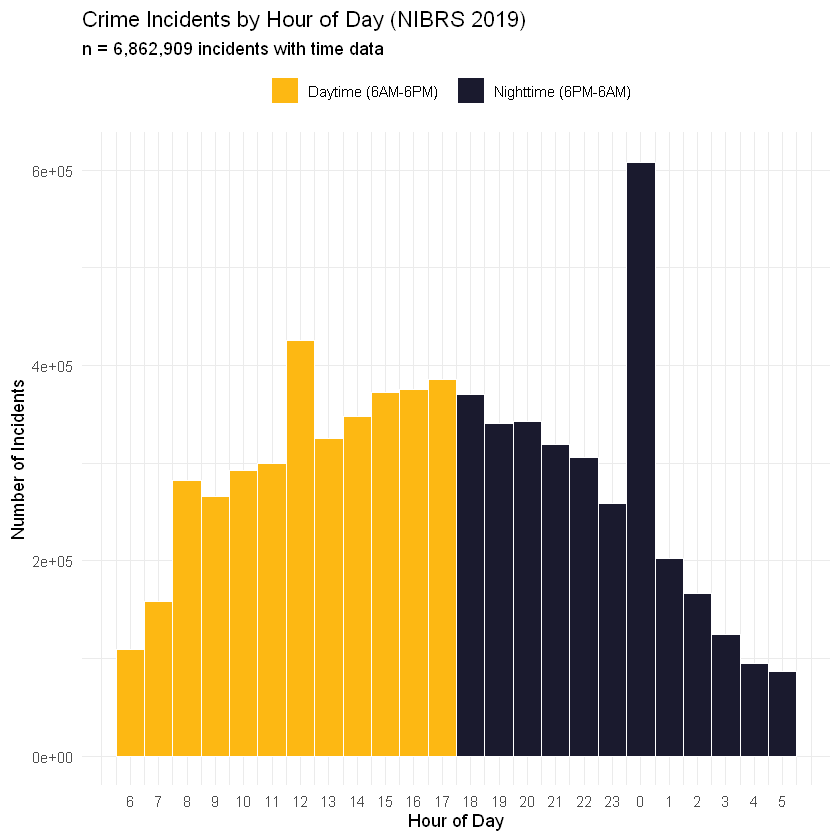

In [8]:
# Visualize hour distribution (starting at 6am so daytime is grouped together)
admin_2019 |>
    filter(!is.na(incident_hour)) |>
    mutate(
        # Shift hours so 6am = 0, making daytime consecutive
        hour_shifted = (incident_hour - 6) %% 24
    ) |>
    ggplot(aes(x = hour_shifted, fill = is_nighttime)) +
    geom_histogram(binwidth = 1, color = "white") +
    scale_x_continuous(
        breaks = 0:23,
        labels = c(6:23, 0:5)  # Labels show actual hours: 6,7,8...23,0,1,2,3,4,5
    ) +
    scale_fill_manual(values = c("FALSE" = "#FDB813", "TRUE" = "#1a1a2e"),
                      labels = c("Daytime (6AM-6PM)", "Nighttime (6PM-6AM)")) +
    labs(title = "Crime Incidents by Hour of Day (NIBRS 2019)",
         subtitle = paste0("n = ", format(sum(!is.na(admin_2019$incident_hour)), big.mark=","), " incidents with time data"),
         x = "Hour of Day",
         y = "Number of Incidents",
         fill = NULL) +
    theme_minimal() +
    theme(legend.position = "top")

In [9]:
# Nighttime vs Daytime summary
cat("=== NIGHTTIME VS DAYTIME CRIME ===", "\n\n")

admin_2019 |>
    filter(!is.na(incident_hour)) |>
    count(is_nighttime) |>
    mutate(
        period = ifelse(is_nighttime, "Nighttime (6PM-6AM)", "Daytime (6AM-6PM)"),
        pct = round(100 * n / sum(n), 1)
    ) |>
    select(period, n, pct) |>
    print()

=== NIGHTTIME VS DAYTIME CRIME === 

               period       n  pct
1   Daytime (6AM-6PM) 3640916 53.1
2 Nighttime (6PM-6AM) 3221993 46.9


## Conclusion

### Data Validation Summary

| Check | Result |
|-------|--------|
| Incident time column exists | `incident_date_hour` |
| Time granularity | Hourly (0-23) |
| Time completeness | 100% |
| County FIPS linkage | Via `batch_header` → `fips_county_code` |
| Can distinguish night vs day | Yes |

### Verdict: Data is SUITABLE for moonlight-crime analysis

The NIBRS Administrative Segment provides hour-level incident timing, allowing us to:
1. Filter to nighttime crimes only (when moonlight matters)
2. Compare nighttime vs daytime crime patterns
3. Link to county via ORI → Batch Header → FIPS code
4. Aggregate to county-month-nighttime level for regression analysis

## 5. Verify County-Level Geographic Linkage

In [10]:
# Load batch header to get county FIPS codes
batch_header <- readRDS("../data/alexr_icprsr_crime_data/batch_header_segment/nibrs_batch_header_1991_2024.rds")

# Filter to 2019 and select key geographic columns
batch_geo <- batch_header |>
    filter(year == 2019) |>
    select(ori, state, city_name, population, fips_county_code_1) |>
    rename(fips_county = fips_county_code_1)

# Join incidents with geographic data (sample for demo)
incidents_with_county <- admin_2019 |>
    head(100000) |>
    left_join(batch_geo, by = c("ori", "state")) |>
    filter(!is.na(fips_county))

cat("=== SAMPLE: Incidents with County Data ===\n\n")
incidents_with_county |>
    select(incident_date, incident_hour, state, city_name, fips_county, is_nighttime) |>
    head(15) |>
    as.data.frame() |>
    print()

cat("\n\nCounty coverage in sample:\n")
cat("Incidents with county FIPS:", format(nrow(incidents_with_county), big.mark=","), "\n")
cat("Unique counties:", n_distinct(incidents_with_county$fips_county), "\n")
cat("Unique cities:", n_distinct(incidents_with_county$city_name), "\n")

=== SAMPLE: Incidents with County Data ===

   incident_date incident_hour   state  city_name fips_county is_nighttime
1     2019-04-08             8  alaska      sitka         220        FALSE
2     2019-08-01            16  alaska     haines         100        FALSE
3     2019-10-19            10  alaska      homer         122        FALSE
4     2019-10-01             0  alaska    wasilla         170         TRUE
5     2019-10-29            15 alabama birmingham          73        FALSE
6     2019-10-01             8 alabama birmingham          73        FALSE
7     2019-03-13            11 alabama birmingham          73        FALSE
8     2019-09-01             8 alabama birmingham          73        FALSE
9     2019-12-21            12 alabama birmingham          73        FALSE
10    2019-07-09            11 alabama birmingham          73        FALSE
11    2019-12-01             0 alabama birmingham          73         TRUE
12    2019-12-01            11 alabama birmingham       